# Anomaly detection - Gabbar

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.externals import joblib

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = ['changeset_id', 'changeset_harmful', 'feature_id', 'feature_type']

## Prepare datasets

In [7]:
labelled_path = '../downloads/anomaly-detection/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.sample(10)

(2152, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
404,47575734,1,156419561,way,0,1,0,3,0,0,0,0,1.54e+05,0.26,0
34,48669878,-1,493400015,way,0,1,0,2,0,0,-11,0,3.86e+08,4.41,0
1477,47332182,1,230536990,way,0,1,0,3,0,0,0,0,1.04e+04,0.08,0
667,47514240,1,276801936,way,0,1,0,3,0,0,0,0,2.05e+03,0.09,0
1206,47403158,1,4254638,way,0,1,0,7,0,0,0,0,2.79e+04,0.07,0
1308,47396441,1,152425775,way,0,1,0,8,0,0,0,0,3.68e+03,0.10,0
1374,47361800,1,31352992,way,0,1,0,7,0,0,0,0,6.01e+04,0.07,0
60,48448356,1,491741530,way,0,1,0,2,0,0,0,0,8.42e+01,0.02,0
972,47455830,1,23037501,way,0,1,0,11,0,0,0,0,7.81e+03,0.08,0
316,47681593,1,134823721,way,0,1,0,2,0,0,0,0,3.25e+02,0.03,0


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (2152, 15)
Shape after dropping duplicates: (2152, 15)


In [10]:
labelled.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,2.15e+03,2152.00,2.15e+03,2.15e+03,2152.00,2152.0,2152.00,2152.00,2152.00,2152.00,2152.00,2.15e+03,2152.00,2.15e+03
mean,4.73e+07,0.95,1.80e+08,2.79e-03,1.00,0.0,6.10,0.60,0.36,0.04,0.02,1.76e+07,0.17,4.65e-04
std,6.57e+05,0.31,1.64e+08,5.27e-02,0.05,0.0,5.35,4.21,3.31,2.23,0.18,3.33e+08,1.10,2.16e-02
min,4.48e+07,-1.00,2.08e+06,0.00e+00,0.00,0.0,2.00,0.00,0.00,-26.00,-1.00,1.76e-02,0.00,0.00e+00
25%,4.73e+07,1.00,2.81e+07,0.00e+00,1.00,0.0,3.00,0.00,0.00,0.00,0.00,5.44e+02,0.03,0.00e+00
50%,4.74e+07,1.00,1.35e+08,0.00e+00,1.00,0.0,4.00,0.00,0.00,0.00,0.00,3.99e+03,0.06,0.00e+00
75%,4.75e+07,1.00,3.29e+08,0.00e+00,1.00,0.0,8.00,0.00,0.00,0.00,0.00,2.50e+04,0.11,0.00e+00
max,4.97e+07,1.00,5.01e+08,1.00e+00,1.00,0.0,62.00,42.00,42.00,22.00,3.00,1.28e+10,30.89,1.00e+00


In [11]:
labelled.sum(numeric_only=True)

changeset_id                 1.02e+11
changeset_harmful            2.05e+03
feature_id                   3.87e+11
action_create                6.00e+00
action_modify                2.15e+03
action_delete                0.00e+00
feature_version              1.31e+04
highway_tag_created          1.29e+03
highway_tag_deleted          7.79e+02
highway_value_difference     9.40e+01
primary_tags_difference      4.20e+01
area_of_feature_bbox         3.78e+10
length_of_longest_segment    3.62e+02
feature_name_touched         1.00e+00
dtype: float64

In [12]:
inliers = labelled[labelled['changeset_harmful'] == 1]
print('Total inliers: {}'.format(inliers.shape))

outliers = labelled[labelled['changeset_harmful'] == -1]
print('Total outliers: {}'.format(outliers.shape))

Total inliers: (2099, 15)
Total outliers: (53, 15)


In [13]:
total = labelled.shape[0]

# 80% of the inliers will be used for training.
training = inliers.iloc[0:round(0.8 * total)]
training = training.reset_index(drop=True)
print('Training dataset (only inliers): {}'.format(training.shape))

# 20% of the inliers will be used for validation.
validation = inliers.iloc[round(0.8 * total):]
validation = validation.reset_index(drop=True)
print('Validation dataset (only inliers): {}'.format(validation.shape))

# 100% of the outliers will be used for validation too.
validation = pd.concat([validation, outliers])
validation = validation.reset_index(drop=True)
print('Validation dataset (inliers + outliers): {}'.format(validation.shape))

Training dataset (only inliers): (1722, 15)
Validation dataset (only inliers): (377, 15)
Validation dataset (inliers + outliers): (430, 15)


## Model training

In [14]:
X = training.drop(non_training_attributes, axis=1)
y = training['changeset_harmful']

In [15]:
model = IsolationForest(random_state=random_state)
model.fit(X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=5,
        verbose=0)

In [16]:
training['prediction'] = model.predict(X)
training['score'] = model.decision_function(X)
training.to_csv(labelled_path + 'training-review.csv', index=False)

In [17]:
model_path = '../gabbar/trained/model.pkl'
joblib.dump(model, model_path, compress=True)

['../gabbar/trained/model.pkl']

In [18]:
matrix = confusion_matrix(y, training['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,0,0
Labelled good,173,1549


In [19]:
report = classification_report(y, training['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          1       1.00      0.90      0.95      1722

avg / total       1.00      0.90      0.95      1722



,score
count,1722.00
mean,0.16
std,0.06
min,-0.27
25%,0.16
50%,0.18
75%,0.19
max,0.19


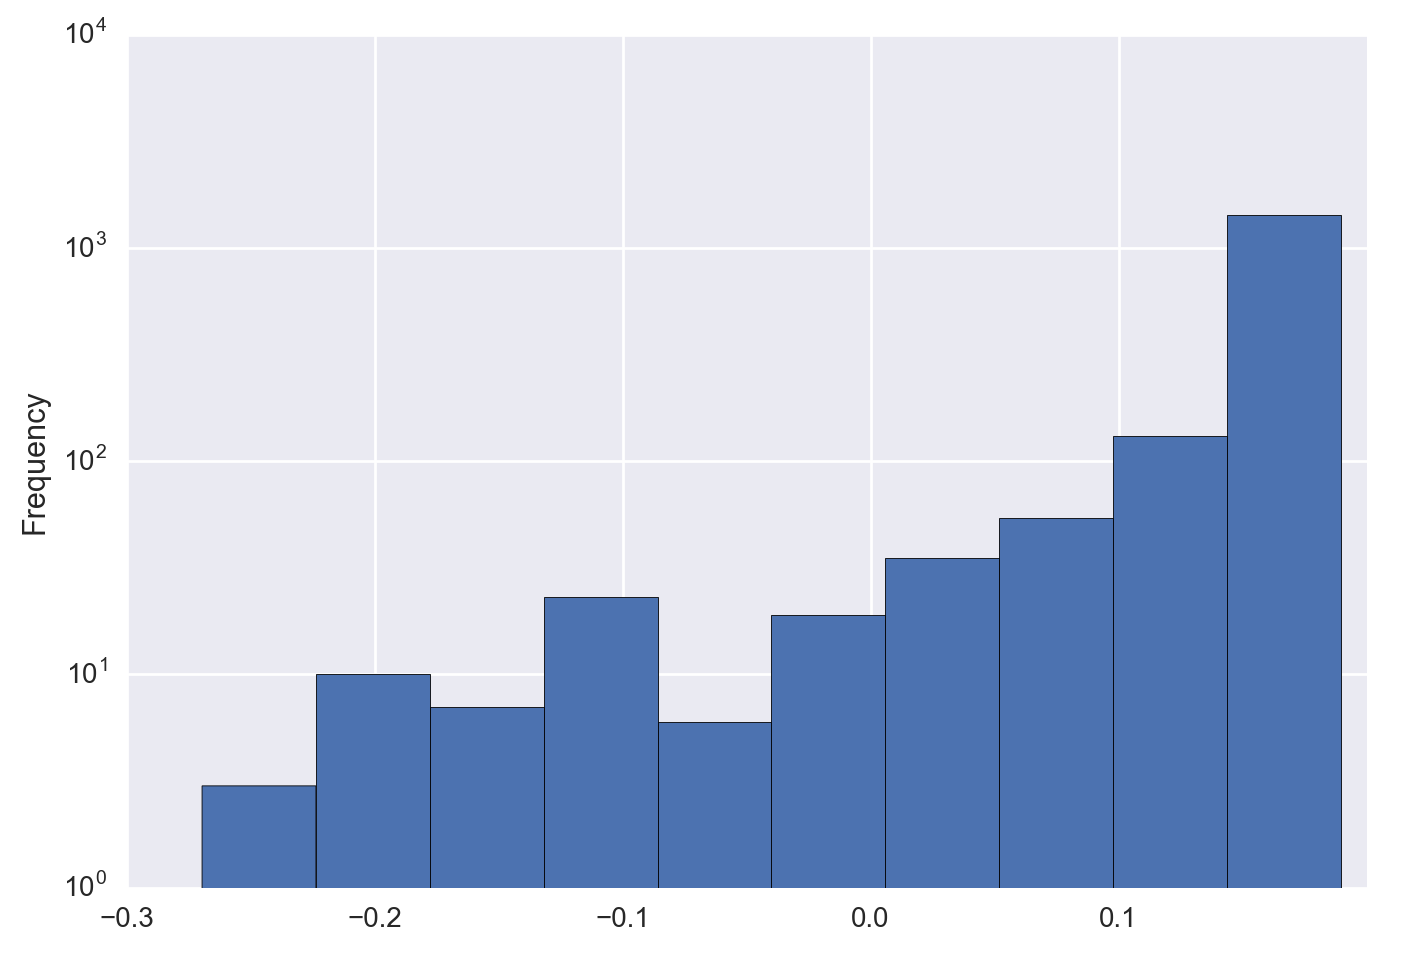

In [20]:
ax = training['score'].plot.hist()
ax.set_yscale('log')

training[['score']].describe()

## Model validation

In [21]:
validation.groupby('changeset_harmful').size()

changeset_harmful
-1     53
 1    377
dtype: int64

In [22]:
vX = validation.drop(non_training_attributes, axis=1)
vy = validation['changeset_harmful']

In [23]:
validation['prediction'] = model.predict(vX)
validation['score'] = model.decision_function(vX)

validation.to_csv(labelled_path + 'validation-review.csv', index=False)

In [24]:
matrix = confusion_matrix(vy, validation['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,37,16
Labelled good,36,341


In [25]:
report = classification_report(vy, validation['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.51      0.70      0.59        53
          1       0.96      0.90      0.93       377

avg / total       0.90      0.88      0.89       430



,score
count,430.00
mean,0.14
std,0.09
min,-0.25
25%,0.14
50%,0.18
75%,0.19
max,0.19


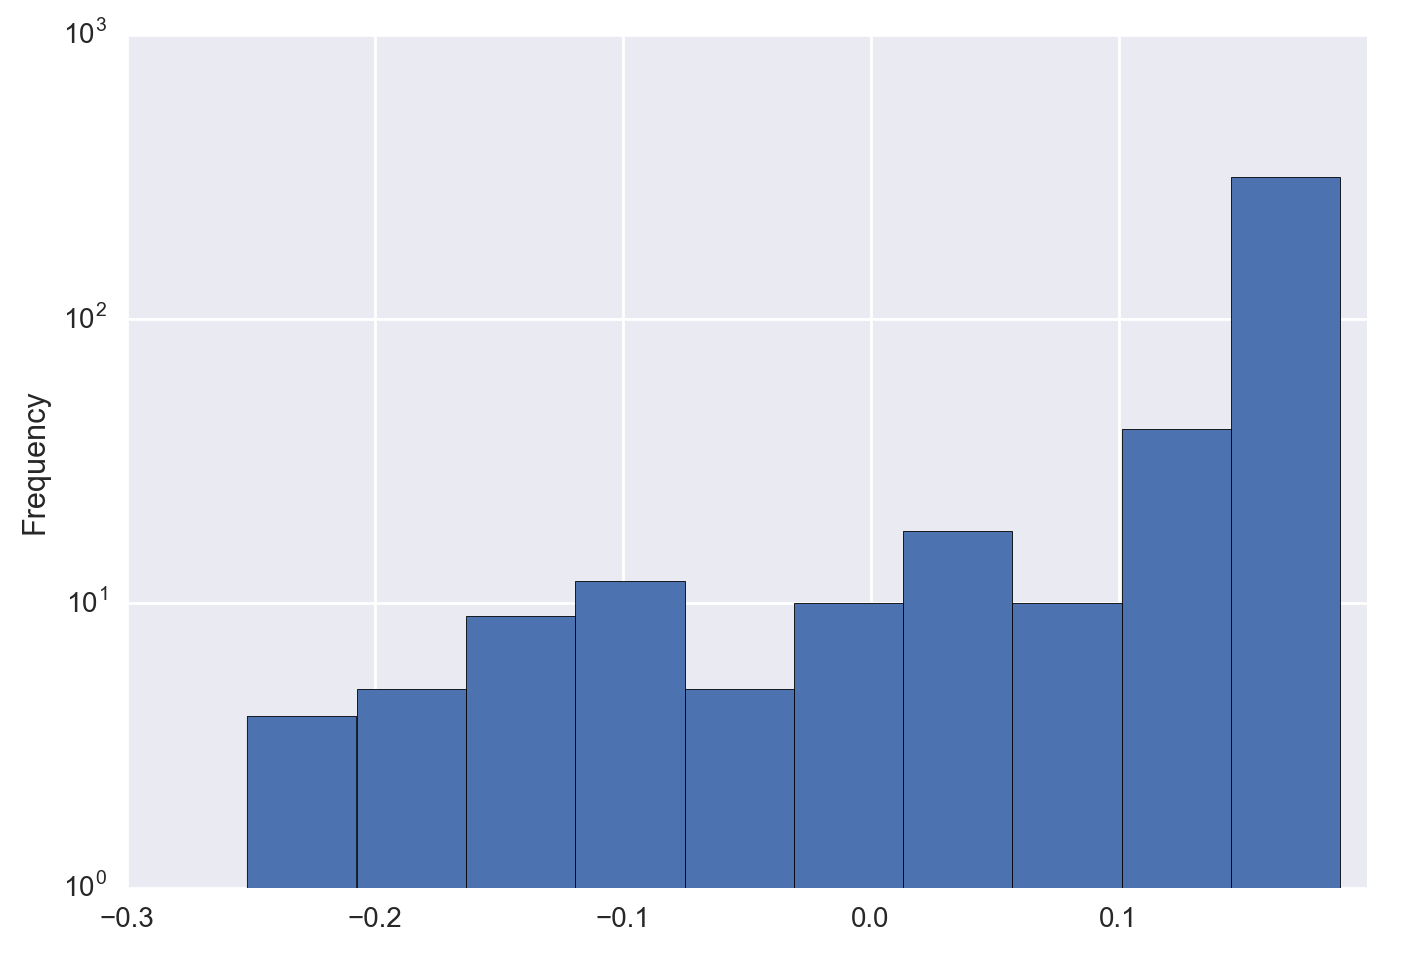

In [26]:
ax = validation['score'].plot.hist()
ax.set_yscale('log')

validation[['score']].describe()

## Model testing

In [27]:
unlabelled_path = testing_path = '../downloads/anomaly-detection/unlabelled/'

In [28]:
unlabelled = pd.read_csv(unlabelled_path + 'attributes.csv')
print(unlabelled.shape)
unlabelled.sample(10)

(260, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
156,49173584,NaN,202305617,way,0,1,0,5,0,0,0,0,24559.06,1.23e-01,0
225,49171835,NaN,311632827,way,0,1,0,2,0,0,0,0,122.33,8.50e-03,0
243,49171344,NaN,118631892,way,0,1,0,5,0,0,0,0,3817.23,2.70e-02,0
91,49176643,NaN,198877204,way,0,1,0,4,0,0,0,0,20681.42,1.24e-01,0
97,49176385,NaN,447119456,way,0,1,0,3,0,0,0,0,20420.57,4.99e-02,0
198,49172388,NaN,83537207,way,0,1,0,2,0,0,-1,0,673.00,3.73e-02,0
50,49178363,NaN,309626776,way,0,1,0,3,0,0,-1,0,284.28,2.75e-02,0
67,49177712,NaN,462182357,way,0,1,0,2,0,0,0,0,43272.35,2.68e-02,0
147,49174264,NaN,6150943,way,0,1,0,6,0,0,0,0,5877.39,4.00e-01,0
115,49175728,NaN,491181958,way,0,1,0,4,0,0,0,0,12.45,0.00e+00,0


In [29]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(unlabelled.shape))
unlabelled = unlabelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(unlabelled.shape))

Shape before dropping duplicates: (260, 15)
Shape after dropping duplicates: (260, 15)


In [30]:
# Using all of the unlabelled dataset for testing.
testing = unlabelled.sample(unlabelled.shape[0])

In [31]:
testing.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,2.60e+02,0.0,2.60e+02,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,2.60e+02,260.00,2.60e+02
mean,4.92e+07,NaN,2.63e+08,0.02,0.97,0.01,4.72,1.42,1.32,-0.99,0.01,2.98e+06,0.12,3.85e-03
std,2.93e+03,NaN,1.77e+08,0.15,0.18,0.11,3.92,6.47,6.50,4.90,0.28,2.70e+07,0.27,6.20e-02
min,4.92e+07,NaN,4.31e+06,0.00,0.00,0.00,1.00,0.00,0.00,-35.00,-1.00,1.95e+00,0.00,0.00e+00
25%,4.92e+07,NaN,9.83e+07,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,9.02e+02,0.03,0.00e+00
50%,4.92e+07,NaN,2.56e+08,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,6.61e+03,0.06,0.00e+00
75%,4.92e+07,NaN,4.39e+08,0.00,1.00,0.00,5.00,0.00,0.00,0.00,0.00,4.30e+04,0.12,0.00e+00
max,4.92e+07,NaN,4.98e+08,1.00,1.00,1.00,28.00,41.00,37.00,16.00,1.00,4.04e+08,3.02,1.00e+00


In [32]:
testing.sum(numeric_only=True)

changeset_id                 1.28e+10
changeset_harmful            0.00e+00
feature_id                   6.83e+10
action_create                6.00e+00
action_modify                2.51e+02
action_delete                3.00e+00
feature_version              1.23e+03
highway_tag_created          3.70e+02
highway_tag_deleted          3.44e+02
highway_value_difference    -2.58e+02
primary_tags_difference      3.00e+00
area_of_feature_bbox         7.75e+08
length_of_longest_segment    3.24e+01
feature_name_touched         1.00e+00
dtype: float64

In [33]:
tX = testing.drop(non_training_attributes, axis=1)
ty = testing['changeset_harmful']

In [34]:
testing['prediction'] = model.predict(tX)
testing['score'] = model.decision_function(tX)

testing.to_csv(unlabelled_path + 'testing-review.csv', index=False)

In [35]:
tharmful_count = testing[testing['prediction'] == -1].shape[0]
tnot_harmful_count = testing[testing['prediction'] == 1].shape[0]

print('Predicted good: {}'.format(tnot_harmful_count))
print('Predicted harmful: {}'.format(tharmful_count))

print('Percentage harmful: {}%'.format(round(100.0 * tharmful_count / testing.shape[0], 2)))

Predicted good: 206
Predicted harmful: 54
Percentage harmful: 20.77%


,score
count,260.00
mean,0.13
std,0.09
min,-0.23
25%,0.12
50%,0.18
75%,0.19
max,0.19


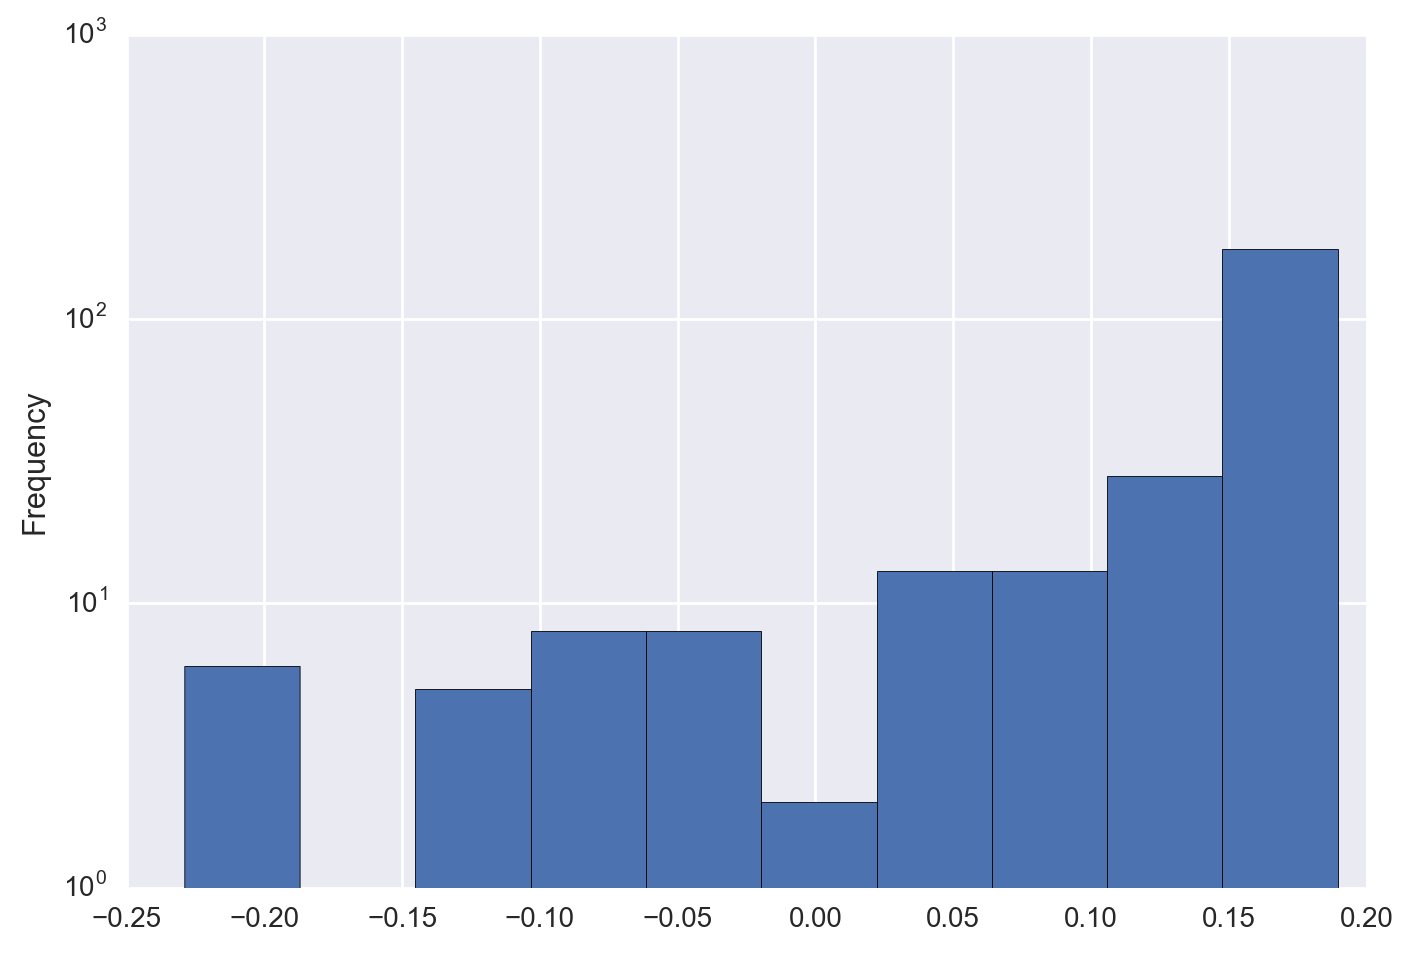

In [36]:
ax = testing['score'].plot.hist()
ax.set_yscale('log')

testing[['score']].describe()